In [1]:
from PIL import Image
# from utils import transform
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch
import cv2
from tqdm import tqdm

In [2]:
import os
import pickle as pk
import json

In [3]:
labels = ('nilam', 'guava', 'sawo', 'taro','bamboo', 'coffeearabica','lychee','aroid','cinnamon',
             'mango','papaya','dragonfruit','vanilla','jackfruit','frangipani','sugarpalm','whitepepper',
             'snakefruit','waterguava','cacao','zodia','starfruit','passiflora','durian','mangosteen','banana')

label_map = {k: v + 1 for v, k in enumerate(labels)}
label_map['background'] = 0

In [22]:
len(label_map)

27

In [6]:
print (label_map['banana'])
print (label_map['cacao'])
label_map['sugarpalm']

26
20


16

In [23]:
def parse_label(label_dict, class_name):
    boxes = list()
    labels = list()
    difficulties = list()
    
    if len(label_dict.keys()) == 1 and 'pottedplant' in label_dict:
        for box in label_dict['pottedplant']:
            boxes.append(box.tolist())
            labels.append(label_map[class_name])
            difficulties.append(0)
            
    return {'boxes': boxes, 'labels': labels, 'difficulties': difficulties}

In [24]:
def create_data_lists(data_path, output_folder):
    data_path = os.path.abspath(data_path)
    output_folder = os.path.abspath(output_folder)

    train_images = list()
    train_objects = list()
    n_objects = 0
    
    for class_name in os.listdir(data_path):
        class_path = os.path.join(data_path, class_name)
        with open(os.path.join(class_path, '{}_labels.pk'.format(class_name)), 'rb') as f:
            ids = pk.load(f)
#         import pdb; pdb.set_trace()
        for id in ids.keys():
            objects = parse_label(ids.get(id), class_name)
            if len(objects['boxes']) == 0:
                continue
            n_objects += len(objects)
            train_objects.append(objects)
            train_images.append(os.path.join(class_path, id))
            
        print (class_path, n_objects)
    
    assert len(train_objects) == len(train_images)

    # Save to file
    with open(os.path.join(output_folder, 'TRAIN_images.json'), 'w') as j:
        json.dump(train_images, j)
    with open(os.path.join(output_folder, 'TRAIN_objects.json'), 'w') as j:
        json.dump(train_objects, j)
    with open(os.path.join(output_folder, 'label_map.json'), 'w') as j:
        json.dump(label_map, j)  # save label map too

    print('\nThere are %d training images containing a total of %d objects. Files have been saved to %s.' % (
        len(train_images), n_objects, os.path.abspath(output_folder)))

In [25]:
create_data_lists("../../data/bali-26/", "../../data/training/")

/home/rts_azure/data/bali-26/nilam 1560
/home/rts_azure/data/bali-26/guava 2817
/home/rts_azure/data/bali-26/sawo 6123
/home/rts_azure/data/bali-26/taro 7557
/home/rts_azure/data/bali-26/bamboo 8895
/home/rts_azure/data/bali-26/coffeearabica 12132
/home/rts_azure/data/bali-26/lychee 13734
/home/rts_azure/data/bali-26/aroid 15945
/home/rts_azure/data/bali-26/cinnamon 17505
/home/rts_azure/data/bali-26/mango 19077
/home/rts_azure/data/bali-26/papaya 20130
/home/rts_azure/data/bali-26/dragonfruit 23487
/home/rts_azure/data/bali-26/vanilla 28326
/home/rts_azure/data/bali-26/jackfruit 32994
/home/rts_azure/data/bali-26/frangipani 34581
/home/rts_azure/data/bali-26/sugarpalm 34734
/home/rts_azure/data/bali-26/whitepepper 39048
/home/rts_azure/data/bali-26/snakefruit 39216
/home/rts_azure/data/bali-26/waterguava 43083
/home/rts_azure/data/bali-26/cacao 43389
/home/rts_azure/data/bali-26/zodia 47385
/home/rts_azure/data/bali-26/starfruit 50208
/home/rts_azure/data/bali-26/passiflora 52155
/hom

## Create data list experiment 2

In [7]:
data_folder = "../../data/training/"
with open(os.path.join(data_folder, 'TRAIN_images.json'), 'r') as j:
    images = json.load(j)
with open(os.path.join(data_folder, 'TRAIN_objects.json'), 'r') as j:
    objects = json.load(j)

In [8]:
print (len(images))

19295


In [9]:
images[0]

'/home/rts_azure/data/bali-26/nilam/1317.jpg'

In [10]:
objects[0]

{'boxes': [[-10.767513275146484,
   68.53013610839844,
   1078.86181640625,
   1913.0101318359375]],
 'labels': [1],
 'difficulties': [0]}

In [13]:
set([1]) - set([16,20,26])

{1}

In [14]:
new_images = []
new_objects = []
for i in tqdm(range(len(images))):
    if len(set(objects[i]['labels']) - set([16,20,26]))== 0:
        continue
        
    h, w, _ = cv2.imread(images[i]).shape
    boxes = []
    labels = []
    for j, box in enumerate(objects[i]['boxes']):
#         print (box)
#         print (h, w)
        if (box[2] - box[0]) * (box[3] - box[1]) >= h * w * 0.3:
            boxes.append(box)
            labels.append(objects[i]['labels'][j])
    
    if len(boxes) > 0:
        new_images.append(images[i])
        data = {
            'boxes': boxes,
            'labels': labels,
            'difficulties': [0] * len(boxes)
        }
        new_objects.append(data)
        

100%|██████████| 19295/19295 [07:17<00:00, 44.07it/s]


In [43]:
print (len(new_images), len(new_objects))

18633 18633


In [40]:
from collections import defaultdict
count = defaultdict(int)
for i in range(len(objects)):
    count[objects[i]['labels'][0]] += 1

In [42]:
label_map

{'nilam': 1,
 'guava': 2,
 'sawo': 3,
 'taro': 4,
 'bamboo': 5,
 'coffeearabica': 6,
 'lychee': 7,
 'aroid': 8,
 'cinnamon': 9,
 'mango': 10,
 'papaya': 11,
 'dragonfruit': 12,
 'vanilla': 13,
 'jackfruit': 14,
 'frangipani': 15,
 'sugarpalm': 16,
 'whitepepper': 17,
 'snakefruit': 18,
 'waterguava': 19,
 'cacao': 20,
 'zodia': 21,
 'starfruit': 22,
 'passiflora': 23,
 'durian': 24,
 'mangosteen': 25,
 'banana': 26,
 'background': 0}

In [41]:
count

defaultdict(int,
            {1: 520,
             2: 419,
             3: 1102,
             4: 478,
             5: 446,
             6: 1079,
             7: 534,
             8: 737,
             9: 520,
             10: 524,
             11: 351,
             12: 1119,
             13: 1613,
             14: 1556,
             15: 529,
             16: 51,
             17: 1438,
             18: 56,
             19: 1289,
             20: 102,
             21: 1332,
             22: 941,
             23: 649,
             24: 898,
             25: 692,
             26: 320})

In [38]:
objects[i-4950]['labels']

[19]

In [36]:
set(objects[i-4900]['labels']) - set([16,20,26])

set()

In [44]:
data_folder = "../../data/training/"
with open(os.path.join(data_folder, 'TRAIN_images2.json'), 'w') as j:
    json.dump(new_images, j)
with open(os.path.join(data_folder, 'TRAIN_objects2.json'), 'w') as j:
    json.dump(new_objects, j)

In [19]:
class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split, keep_difficult=False):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.upper()

        assert self.split in {'TRAIN', 'TEST'}

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        # Read data files
        with open(os.path.join(data_folder, self.split + '_images.json'), 'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split + '_objects.json'), 'r') as j:
            self.objects = json.load(j)

        assert len(self.images) == len(self.objects)

    def __getitem__(self, i):
        # Read image

        image = Image.open(self.images[i], mode='r')
        image = image.convert('RGB')
        plt.imshow(image)
        plt.show()
#         import pdb; pdb.set_trace()
        # Read objects in this image (bounding boxes, labels, difficulties)
        import pdb; pdb.set_trace()
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects['boxes'])  # (n_objects, 4)
        labels = torch.LongTensor(objects['labels'])  # (n_objects)
        difficulties = torch.ByteTensor(objects['difficulties'])  # (n_objects)

        # Discard difficult objects, if desired
        if not self.keep_difficult:
            boxes = boxes[1 - difficulties]
            labels = labels[1 - difficulties]
            difficulties = difficulties[1 - difficulties]

        # Apply transformations
        image, boxes, labels, difficulties = transform(image, boxes, labels, difficulties, split=self.split)

        return image, boxes, labels, difficulties

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).

        This describes how to combine these tensors of different sizes. We use lists.

        Note: this need not be defined in this Class, can be standalone.

        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()
        difficulties = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            difficulties.append(b[3])

        images = torch.stack(images, dim=0)

        return images, boxes, labels, difficulties  # tensor (N, 3, 300, 300), 3 lists of N tensors each

In [14]:
data_folder = '../../data/training'  # folder with data files
train_dataset = PascalVOCDataset(data_folder, split='train', keep_difficult=True)

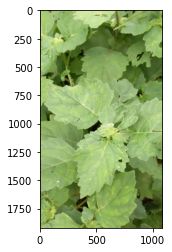

> <ipython-input-13-a987421080e5>(37)__getitem__()
     35         # Read objects in this image (bounding boxes, labels, difficulties)
     36         import pdb; pdb.set_trace()
---> 37         objects = self.objects[i]
     38         boxes = torch.FloatTensor(objects['boxes'])  # (n_objects, 4)
     39         labels = torch.LongTensor(objects['labels'])  # (n_objects)

ipdb> n
> <ipython-input-13-a987421080e5>(38)__getitem__()
     36         import pdb; pdb.set_trace()
     37         objects = self.objects[i]
---> 38         boxes = torch.FloatTensor(objects['boxes'])  # (n_objects, 4)
     39         labels = torch.LongTensor(objects['labels'])  # (n_objects)
     40         difficulties = torch.ByteTensor(objects['difficulties'])  # (n_objects)

ipdb> n
> <ipython-input-13-a987421080e5>(39)__getitem__()
     37         objects = self.objects[i]
     38         boxes = torch.FloatTensor(objects['boxes'])  # (n_objects, 4)
---> 39         labels = torch.LongTensor(objects['labels

NameError: name 'transform' is not defined

In [15]:
train_dataset[0]